In [ ]:
"""
notebook: 1.3.-leibold-data-modeling_randomForest.jpynb

author: Christian Leibold

created/updated at: 2025-11-28

intention: create preprocessing pipeline to prepare data from concat joblib. 
           use random forest model with smote to create a first baseline model. 

content:
---------
-> reads in joblib with concatenated data from prior process stept with csv-files for 2019-2024 as base for this notebook 
-> create a pipeline with most important preprocessing steps
-> create random forest model + smote resampling
-> save model to local storage
"""

In [11]:
# classic packages
import pandas as pd
import numpy as np
from joblib import dump, load

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# make custom libraries importable
import sys
sys.path.append('../../library')

# pipeline compatibel classes
from road_accidents_pipeline import RemoveIrrelevantCols         # removes some unnecessary columns
from road_accidents_pipeline import RearrangeCatCols             # bundle veh classes together to higher-tier classes
from road_accidents_pipeline import ConditionalMultiQuantImputer # impute missing values of quantiative variables via distr. on cat var
from road_accidents_pipeline import ConditionalCatImputer        # impute missing values of categorcial variables on target distribution
from road_accidents_pipeline import AggrLocaSplit                # aggregation of loca intersections incl. oneHotEncoding 
from road_accidents_pipeline import SupervisedEncoderWrapper     # wrapper for supervised encoders like CatBoostEncoder or TargetEncoder to make it work in pipeline
from road_accidents_pipeline import RemoveIdCols                 # removes ind_temp_id and acc_num after aggregation

# imputer
from sklearn.impute import SimpleImputer

# scaler
from sklearn.preprocessing import MinMaxScaler, RobustScaler

# encoder
from sklearn.preprocessing import OneHotEncoder, SplineTransformer
from sklearn.preprocessing import FunctionTransformer
from category_encoders import TargetEncoder, CatBoostEncoder

# train_test_split
from sklearn.model_selection import train_test_split

# evaluation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# resampling
from imblearn.over_sampling import SMOTE

# model classifier
from sklearn.ensemble import RandomForestClassifier

# little helper
from cleaning_utils import distinguish_cols, print_col_categories
import time


In [2]:
df = load(r'..\..\..\temp_data\1.2-leibold-data-preprocessing_concat.joblib')
#df = df.loc[df['acc_year']==2024]
#df = df.sample(n=10000)

print(df.shape)
display(df.head(3))

(762666, 44)


,acc_num,ind_place,ind_cat,ind_severity,ind_sex,ind_trip,ind_secu1,ind_secu2,ind_location,ind_action,...,veh_id,loca_road_cat,loca_traffic_circul,loca_road_lanes,loca_road_gradient,loca_road_view,loca_road_surface_cond,loca_accident,loca_max_speed,loca_is_intersection
0,201900000001,2,2,2,2,0,1,0,<NA>,<NA>,...,138 306 524,1,3,10.0,1,2.0,1.0,1,70.0,0
1,201900000001,1,1,2,2,5,1,0,<NA>,<NA>,...,138 306 524,1,3,10.0,1,2.0,1.0,1,70.0,0
2,201900000001,1,1,1,1,0,1,0,<NA>,<NA>,...,138 306 525,1,3,10.0,1,2.0,1.0,1,70.0,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 762666 entries, 0 to 807331
Data columns (total 44 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   acc_num                 762666 non-null  int64         
 1   ind_place               762666 non-null  int64         
 2   ind_cat                 762666 non-null  int64         
 3   ind_severity            762666 non-null  int64         
 4   ind_sex                 762666 non-null  int64         
 5   ind_trip                762666 non-null  int64         
 6   ind_secu1               761592 non-null  Int64         
 7   ind_secu2               459219 non-null  Int64         
 8   ind_location            410831 non-null  Int64         
 9   ind_action              440404 non-null  Int64         
 10  ind_year                762666 non-null  int64         
 11  ind_age                 762666 non-null  Int64         
 12  ind_age_group           762666 non-

In [4]:
# -------------------------------------------------------------------------------------------------
# data split
# -------------------------------------------------------------------------------------------------
# Separate features and target
X = df.drop(columns=['ind_severity'])   # predictors
y = df['ind_severity']                  # target

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# check shapes
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (610132, 43)
y_train shape: (610132,)
X_test shape: (152534, 43)
y_test shape: (152534,)


In [5]:
# -------------------------------------------------------------------------------------------------
# check missing values
# -------------------------------------------------------------------------------------------------
missing_vars = X_train.isna().sum()
missing_vars = missing_vars[missing_vars > 0]
print(missing_vars)

ind_secu1                    857
ind_secu2                 242790
ind_location              281328
ind_action                257770
acc_ambient_lightning          8
acc_atmosphere                30
acc_intersection              24
acc_collision_type          2961
veh_impact                   252
veh_maneuver               34327
loca_road_lanes            17817
loca_road_view               380
loca_road_surface_cond       495
loca_max_speed             18832
dtype: int64


In [6]:
# -------------------------------------------------------------------------------------------------
# define columns to be operated: read in columns from dictionary for later use in pipeline
# -------------------------------------------------------------------------------------------------
cols_dict = distinguish_cols(df)

cat_cols = cols_dict["categorical"] # Get all categorical variables from cols_dict
missing_cat_cols = [col for col in cat_cols if col in X_train.columns and X_train[col].isna().any()] # Restrict to those with missing values

ohe_cols = cols_dict['oneHot_encoder']


⚠️ Missing columns (ignored): ['loca_road_count']


In [7]:
# -------------------------------------------------------------------------------------------------
# Full preprocessing pipeline
# -------------------------------------------------------------------------------------------------
# Pipeline with most important preprocessing steps. can be reused in other notebooks. 
# needs concatenated data as input.
# for the whole dataset takes about 11 minutes -> so try with smaller data sample first. 

# steps:
# --------------------------------------------------------
# - RemoveIrrelevantCols: Drops columns not useful for prediction.
# - ConditionalMultiQuantImputer: Imputes missing numeric values based on road category.
# - ConditionalCatImputer: Fills missing categorical values conditionally on target distribution.
# - AggrLocaSplit: Aggregates location features for intersections.
# - RemoveIdCols: Removes identifier columns used in aggregation.
# - RearrangeCatCols: merge some classes in veh categorical columns to reduce cardinatliy.
# - ColumnTransformer: Applies spline encoding, one-hot, CatBoost encoding, and scaling to features.


# Start timer
start_time = time.time()

# instantiate encoders
ohe_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False, dtype='int')
spline_hour = SplineTransformer(degree=3, knots=np.linspace(0, 23, num=6).reshape(-1, 1), extrapolation='periodic', include_bias=True)
spline_month = SplineTransformer(degree=3, knots=np.linspace(1, 12, num=4).reshape(-1, 1), extrapolation='periodic', include_bias=True)
catboost_encoder = SupervisedEncoderWrapper(CatBoostEncoder(handle_unknown='value', handle_missing='value'), columns=["acc_municipality"])

# instantiate Scaler
scaler = MinMaxScaler()

# Combine everything into one pipeline
preprocessing_pipeline = Pipeline([
    # data preparation
    ("remove_cols", RemoveIrrelevantCols(verbose=True)),

    # imputing
    ("impute_quant", ConditionalMultiQuantImputer(
        quant_vars=["loca_max_speed", "loca_road_lanes"],
        cat_var="loca_road_cat"
    )),
    ("impute_cat", ConditionalCatImputer(var_list=cat_cols)),

    # aggregation
    ("aggregate", AggrLocaSplit(agg_features="max", agg_target="max")),
    ("remove_id_cols", RemoveIdCols(verbose=True)),

    # encoding & scaling
    ("rearrange_categories", RearrangeCatCols(verbose=True)),
    ("encode_scale", ColumnTransformer([
        ("spline_hour", spline_hour, ["acc_hour"]),
        ("spline_month", spline_month, ["acc_month"]),
        ("onehot", ohe_encoder, lambda X: [c for c in ohe_cols if c in X.columns]),
        ("catboost", catboost_encoder, ["acc_municipality"]),
        ("scale", scaler, cols_dict["quantitative"])
    ], remainder="passthrough"))
    
], verbose=True)


# Fit the pipeline
preprocessing_pipeline.fit(X_train, y_train)

# Transform training and test data
X_train_piped = preprocessing_pipeline.transform(X_train)
X_test_piped = preprocessing_pipeline.transform(X_test)

# Access the fitted aggregation step
aggr_step = preprocessing_pipeline.named_steps["aggregate"]

# Transform y consistently (because the aggregation step reduces row count in X -> so y must also be reduced to avoid mismatch error
y_train_piped = aggr_step.transform_y(X_train, y_train)
y_test_piped  = aggr_step.transform_y(X_test, y_test)


# End timer
end_time = time.time()
elapsed_minutes = (end_time - start_time) / 60
print(f"⏱️ Preprocessing Pipeline fit completed in {elapsed_minutes:.2f} minutes")


[Pipeline] ....... (step 1 of 7) Processing remove_cols, total=   0.1s
[Pipeline] ...... (step 2 of 7) Processing impute_quant, total= 2.4min
ℹ️ ConditionalCatImputer -> Column 'ind_location' not found, skipping.
ℹ️ ConditionalCatImputer -> Column 'ind_action' not found, skipping.
ℹ️ ConditionalCatImputer -> Column 'ind_secu2' not found, skipping.
[Pipeline] ........ (step 3 of 7) Processing impute_cat, total= 2.5min
[Pipeline] ......... (step 4 of 7) Processing aggregate, total=  18.4s
[Pipeline] .... (step 5 of 7) Processing remove_id_cols, total=   0.1s
[Pipeline]  (step 6 of 7) Processing rearrange_categories, total=   0.4s
[Pipeline] ...... (step 7 of 7) Processing encode_scale, total=   4.5s
⏱️ Pipeline fit completed in 11.11 minutes


In [8]:
# --------------------------------------------------------------------------------------------------
# Random Forest Standard + SMOTE
# --------------------------------------------------------------------------------------------------
start = time.time()

smote = SMOTE(random_state=42)

#X_train_piped = X_train_piped.astype(float)
#y_train_piped = y_train_piped.astype(int)  # labels must be integers

# X_test_piped = X_test_piped.astype(float)
# y_test_piped = y_test_piped.astype(int)  # labels must be integers

X_train_smote, y_train_smote = smote.fit_resample(X_train_piped, y_train_piped)

print("Before SMOTE:", y_train_piped.value_counts())
print("After SMOTE:", y_train_smote.value_counts())

# Initialize RandomForest model
rf_smote = RandomForestClassifier(
    n_estimators=200,        # number of trees
    max_depth=None,          # let trees expand fully
    min_samples_split=2,     # default split criteria
    min_samples_leaf=1,      # default leaf size
    random_state=42,         # reproducibility
    n_jobs=-1,                # use all cores for speed
    #class_weight="balanced"
)

# Fit the model
rf_smote.fit(X_train_smote, y_train_smote)

# Predict on test and train set
y_pred_smote = rf_smote.predict(X_test_piped)
y_train_smote_pred = pred_smote_train = rf_smote.predict(X_train_piped)

end = time.time()
print("Total runtime (minutes):", (end - start) / 60)



Before SMOTE: y
1    233622
2    229468
3     86943
4     14841
Name: count, dtype: int64
After SMOTE: y
2    233622
1    233622
4    233622
3    233622
Name: count, dtype: int64
Total runtime (minutes): 10.385366360346476


✅ RandomForest Results
Accuracy train: 0.9982031391071283
Accuracy test: 0.7084535834535834

Classification Report:
               precision    recall  f1-score   support

           1       0.76      0.84      0.80     62183
           2       0.70      0.69      0.70     60894
           3       0.55      0.47      0.51     22786
           4       0.48      0.18      0.26      3825

    accuracy                           0.71    149688
   macro avg       0.62      0.55      0.57    149688
weighted avg       0.70      0.71      0.70    149688



col_0,1,2,3,4
y,,,,
1,52350,8073,1699,61
2,13162,42248,5264,220
3,2562,9006,10767,451
4,362,957,1824,682


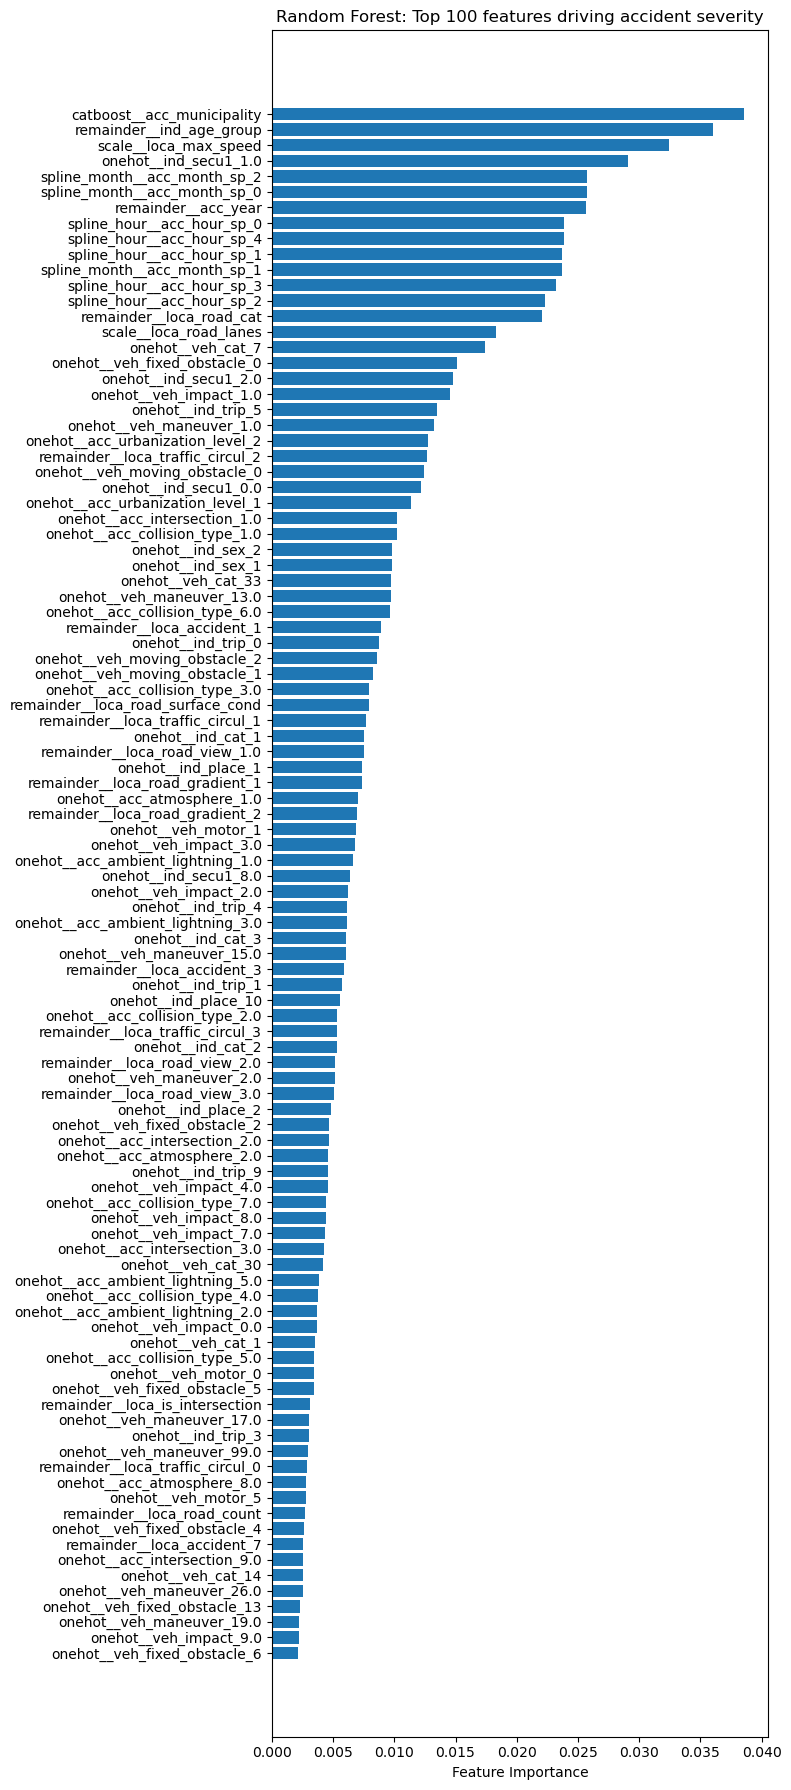

In [25]:
# --------------------------------------------------------------------------------------------------
# Evaluate performance
# --------------------------------------------------------------------------------------------------
print("✅ RandomForest Results")

# accuracy score to check if overfitted
print("Accuracy train:", accuracy_score(y_train_piped, y_train_smote_pred))
print("Accuracy test:", accuracy_score(y_test_piped, y_pred_smote))

# classifiction report
print("\nClassification Report:\n", classification_report(y_test_piped, y_pred_smote))

# confustion matrix
display(pd.crosstab(y_test_piped, y_pred_smote))
#print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


# --------------------------------------------------------------------------------------------------
# Feature importance
# --------------------------------------------------------------------------------------------------
# pipline has np.array as output -> for feature_names a pd.DataFrame must be created to plot feature_importances_
feature_names = preprocessing_pipeline.named_steps["encode_scale"].get_feature_names_out()
X_train_piped_df = pd.DataFrame(X_train_piped, columns=feature_names)

# Get feature importances from the trained RandomForest
importances = rf_smote.feature_importances_
#feature_names = X_train_smote.columns

# Sort by importance
indices = np.argsort(importances)[::-1][:100]  # top 100

plt.figure(figsize=(8, 18))
plt.barh(range(len(indices)), importances[indices][::-1], align="center", height=0.8)
plt.yticks(range(len(indices)), feature_names[indices][::-1])
plt.xlabel("Feature Importance")
plt.title("Random Forest: Top 100 features driving accident severity")
plt.tight_layout()
plt.show()

In [18]:
# check where certain value from error comes from
ct = preprocessing_pipeline.named_steps["encode_scale"]
feature_names = ct.get_feature_names_out()

X_test_df = pd.DataFrame(y_test_piped, columns=feature_names)

mask = (X_test_df == "202300001812_155\xa0677\xa0352_497812").any(axis=1)
rows_with_value = X_test_df[mask]

col_mask = (X_test_df == "202300001812_155\xa0677\xa0352_497812").any()
print("Column(s) containing the value:", col_mask[col_mask].index.tolist())

Column(s) containing the value: []


In [20]:
# see all feature names from pipeline output array

# 1. Get feature names from the ColumnTransformer step
ct = preprocessing_pipeline.named_steps["encode_scale"]
feature_names = ct.get_feature_names_out()

# 2. Wrap the pipeline output into a DataFrame
X_test_df = pd.DataFrame(X_test_piped, columns=feature_names)

for i, col in enumerate(X_test_df.columns):
    print(f"{i:3d}  {col}")

  0  spline_hour__acc_hour_sp_0
  1  spline_hour__acc_hour_sp_1
  2  spline_hour__acc_hour_sp_2
  3  spline_hour__acc_hour_sp_3
  4  spline_hour__acc_hour_sp_4
  5  spline_month__acc_month_sp_0
  6  spline_month__acc_month_sp_1
  7  spline_month__acc_month_sp_2
  8  onehot__acc_ambient_lightning_1.0
  9  onehot__acc_ambient_lightning_2.0
 10  onehot__acc_ambient_lightning_3.0
 11  onehot__acc_ambient_lightning_4.0
 12  onehot__acc_ambient_lightning_5.0
 13  onehot__acc_urbanization_level_1
 14  onehot__acc_urbanization_level_2
 15  onehot__acc_intersection_1.0
 16  onehot__acc_intersection_2.0
 17  onehot__acc_intersection_3.0
 18  onehot__acc_intersection_4.0
 19  onehot__acc_intersection_5.0
 20  onehot__acc_intersection_6.0
 21  onehot__acc_intersection_7.0
 22  onehot__acc_intersection_8.0
 23  onehot__acc_intersection_9.0
 24  onehot__acc_atmosphere_1.0
 25  onehot__acc_atmosphere_2.0
 26  onehot__acc_atmosphere_3.0
 27  onehot__acc_atmosphere_4.0
 28  onehot__acc_atmosphere_5.0
 

In [27]:
# --------------------------------------------------------------------------------------------------
# safe model
# --------------------------------------------------------------------------------------------------
#dump(rf_smote, "../../models/model_rf_smote")
dump(rf_smote, "C:/Users/Christian/Documents/model_rf_smote")


['C:/Users/Christian/Documents/model_rf_smote']

In [14]:
# -------------------------------------------------------------------------------------------------
# Preprocessing Pipeline
# -------------------------------------------------------------------------------------------------
# Start timer
start_time = time.time()

# pipeline 1: data preparation
#--------------------------------------------------
prep_pipeline = Pipeline(steps=[
                    ("remove_cols", RemoveIrrelevantCols(verbose=True)),
                ])

# pipeline 2: imputation and aggregation
#--------------------------------------------------
aggr_pipeline = Pipeline(steps=[
            ('impute_quant', ConditionalMultiQuantImputer(quant_vars=['loca_max_speed', 'loca_road_lanes'], cat_var='loca_road_cat')),
            ('impute_cat', ConditionalCatImputer(var_list=missing_cat_cols)),
            ('aggr', AggrLocaSplit(agg_features="max", agg_target="max")), 
            ("remove_id_cols", RemoveIdCols(verbose=True))
          ])

# pipeline 3: encoding and scaling
#--------------------------------------------------
# instantiate encoders
ohe_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False, dtype='int')
spline_hour = SplineTransformer(degree=3, knots=np.linspace(0, 23, num=6).reshape(-1, 1), extrapolation='periodic', include_bias=True)
spline_month = SplineTransformer(degree=3, knots=np.linspace(1, 12, num=4).reshape(-1, 1), extrapolation='periodic', include_bias=True)
catboost_encoder = SupervisedEncoderWrapper(CatBoostEncoder(handle_unknown='impute', handle_missing='impute'), columns=["acc_municipality"])

# instantiate Scaler
scaler = MinMaxScaler()

encoding_scaling_pipeline = Pipeline([
    ("rearrange_categories", RearrangeCatCols(verbose=True)),
    ("encode_scale", ColumnTransformer([
        ('spline_hour', spline_hour, ['acc_hour']),
        ('spline_month', spline_month, ['acc_month']),
        ('onehot', ohe_encoder, lambda X: [c for c in ohe_cols if c in X.columns]),
        ('catboost', catboost_encoder, ["acc_municipality"]),
        ('scale', scaler, cols_dict['quantitative'])
    ], remainder='passthrough'))
])

# pipeline 4: final preprocessing 
#--------------------------------------------------
preprocessing_pipeline = Pipeline([
    ("prep", prep_pipeline),
    ("aggregate", aggr_pipeline),
    ("encoding_scaling", encoding_scaling_pipeline)
])

# Fit the pipeline
preprocessing_pipeline.fit(X_train, y_train)

# Transform training and test data
X_train_piped = preprocessing_pipeline.transform(X_train)
X_test_piped  = preprocessing_pipeline.transform(X_test)

# Access the fitted aggregation step
aggr_step = preprocessing_pipeline.named_steps["aggregate"].named_steps["aggr"]

# Transform y consistently
y_train_piped = aggr_step.transform_y(X_train, y_train)
y_test_piped  = aggr_step.transform_y(X_test, y_test)



# End timer
end_time = time.time()

elapsed_minutes = (end_time - start_time) / 60
print(f"⏱️ Preprocessing Pipeline fit completed in {elapsed_minutes:.2f} minutes")


ℹ️ ConditionalCatImputer -> Column 'ind_location' not found, skipping.
ℹ️ ConditionalCatImputer -> Column 'ind_action' not found, skipping.
ℹ️ ConditionalCatImputer -> Column 'ind_secu2' not found, skipping.


C:\Users\Christian\.conda\envs\dst_project\Lib\site-packages\sklearn\pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
C:\Users\Christian\.conda\envs\dst_project\Lib\site-packages\sklearn\pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
C:\Users\Christian\.conda\envs\dst_project\Lib\site-packages\sklearn\pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
C:\Users\Christian\.conda\envs\dst_pr

⏱️ Preprocessing Pipeline fit completed in 0.03 minutes
